In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

In [6]:
# import cv2
# import os

# # Define dataset folders
# input_folders = {
#     "test_mask": "./dataset/test/mascarilla",
#     "test_no_mask": "./dataset/test/no_mascarilla",
#     "train_mask": "./dataset/train/mascarilla",
#     "train_no_mask": "./dataset/train/no_mascarilla",
# }

# def resize_images(input_folder, size=(128, 128)):
#     """Resizes all images in a folder to the given size."""
#     for filename in os.listdir(input_folder):
#         if filename.lower().endswith((".jpg", ".png", ".jpeg")):  # Filter valid images
#             image_path = os.path.join(input_folder, filename)
            
#             # Load and validate image
#             image = cv2.imread(image_path)
#             if image is None:
#                 continue  # Skip invalid images

#             # Resize and overwrite image
#             resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
#             cv2.imwrite(image_path, resized_image)

#     print(f"Resizing complete for: {input_folder}")

# # Process all folders
# for folder in input_folders.values():
#     resize_images(folder)

In [7]:
train_dataset = image_dataset_from_directory(
    './dataset/train',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    class_names = ['mascarilla', 'no_mascarilla']
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    './dataset/train',  # Usar el mismo directorio de entrenamiento para la validación
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    class_names=['mascarilla', 'no_mascarilla']
)

test_dataset = image_dataset_from_directory(
    './dataset/test',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    subset="validation",
    validation_split=0.2,
    class_names = ['mascarilla', 'no_mascarilla']
)

Found 656 files belonging to 2 classes.
Using 525 files for training.
Found 656 files belonging to 2 classes.
Using 131 files for validation.
Found 160 files belonging to 2 classes.
Using 32 files for validation.


In [8]:
class_names = train_dataset.class_names
print(class_names)

['mascarilla', 'no_mascarilla']


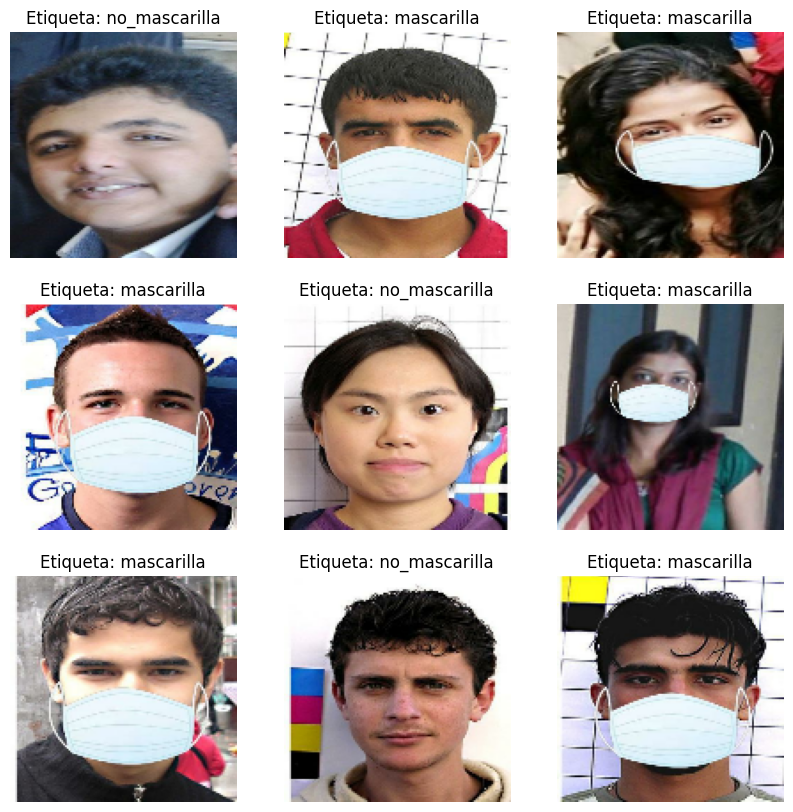

In [10]:

class_names = ['mascarilla', 'no_mascarilla']
for images, labels in train_dataset.take(1):  
    images = images.numpy().astype("uint8")  
    labels = labels.numpy() 

    # Mostrar las primeras 9 imágenes
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  
        plt.title(f"Etiqueta: {class_names[int(labels[i])]}")
        plt.axis("off")
    plt.show()
    break

In [11]:
# Obtener un batch del dataset
for images, labels in train_dataset.take(1):  # Toma el primer batch
    print("Shape de las imágenes:", images.shape)  # Shape de las imágenes
    print("Shape de las etiquetas:", labels.shape)

Shape de las imágenes: (32, 128, 128, 3)
Shape de las etiquetas: (32, 1)


In [12]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU


In [ ]:
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation

normalization = Rescaling(1./255)

data_augmentation = Sequential([
 RandomFlip("horizontal"), # Volteo horizontal
 RandomRotation(0.2), # Rotaciones 20% 
 RandomZoom(0.1), # Zoom hasta 10%
 RandomTranslation(0.1, 0.1) # Desplaz. vertical y horizontal
])
train_dataset = train_dataset.map(lambda x, y:(data_augmentation(normalization(x)), y))
test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))


In [14]:
batch_size = 32
epochs = 20
num_classes = 2

In [15]:
# Definir el modelo de clasificación
clasification_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [16]:
# Compilar el modelo
clasification_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Resumen del modelo
clasification_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 


 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
          

In [18]:
# Entrenar el modelo
batch_size = 32
epochs = 20
clasification_train = clasification_model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data=validation_dataset)

Epoch 1/20
17/17 [==============================] - 8s 421ms/step - loss: 0.7177 - accuracy: 0.5619 - val_loss: 3.6794 - val_accuracy: 0.8702
Epoch 2/20
17/17 [==============================] - 7s 379ms/step - loss: 0.5315 - accuracy: 0.7543 - val_loss: 52.2417 - val_accuracy: 0.8244
Epoch 3/20
17/17 [==============================] - 6s 359ms/step - loss: 0.2945 - accuracy: 0.8990 - val_loss: 32.3826 - val_accuracy: 0.9160
Epoch 4/20
17/17 [==============================] - 7s 379ms/step - loss: 0.2513 - accuracy: 0.9067 - val_loss: 36.1495 - val_accuracy: 0.9008
Epoch 5/20
17/17 [==============================] - 7s 386ms/step - loss: 0.2184 - accuracy: 0.9314 - val_loss: 14.1188 - val_accuracy: 0.9542
Epoch 6/20
17/17 [==============================] - 7s 363ms/step - loss: 0.1949 - accuracy: 0.9352 - val_loss: 22.4343 - val_accuracy: 0.9389
Epoch 7/20
17/17 [==============================] - 6s 369ms/step - loss: 0.1345 - accuracy: 0.9524 - val_loss: 26.9373 - val_accuracy: 0.9160


1/1 [==============================] - 0s 169ms/step
Classification Report:
               precision    recall  f1-score   support

   mascarilla       0.43      0.43      0.43        14
no_mascarilla       0.56      0.56      0.56        18

     accuracy                           0.50        32
    macro avg       0.49      0.49      0.49        32
 weighted avg       0.50      0.50      0.50        32



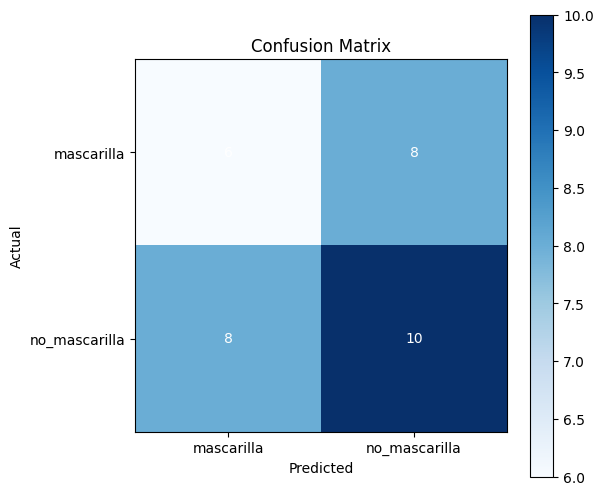

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = clasification_model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['mascarilla', 'no_mascarilla']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')

# Agregar los números dentro de las celdas
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white')

plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0, 1], labels=['mascarilla', 'no_mascarilla'])
plt.yticks(ticks=[0, 1], labels=['mascarilla', 'no_mascarilla'])
plt.title('Confusion Matrix')
plt.show()